# Classification

## Imports

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import anndata as ad
# import scanpy as sc
from collections import Counter
os.environ['SCIPY_ARRAY_API'] = '1'
# from imblearn import over_sampling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from flaml import AutoML
# import 

## Load embeddings and metadata

In [2]:
data = pd.read_csv('../data/processed/dataset_w_cdr_annotation.csv', index_col=0)
# data.index = data['Antibody  Name']
# data.drop('Antibody  Name', axis=1, inplace=True)
display(data)

,Epitope Group,source,D614G,BA.1,BA.2,BA.2.75,BA.5,BQ.1.1,XBB,Heavy chain V gene,...,clus_vh,clus_vl,connected,partition,CDRH1,CDRH2,CDRH3,CDRL1,CDRL2,CDRL3
Antibody Name,,,,,,,,,,,,,,,,,,,,,
BD-196,C,WT convalescents,1.93,>10,>10,>10,>10,>10,>10,IGHV1-3,...,1442,682,0,Validation,GYTF----TSYA,INAG--NGNT,ASRREQWLGDLGYYYYGMDV,QSLVYS-DGNTY,KV-------S,MQGTH----SPWT
BD-218,A,WT convalescents,0.0104,0.00849,0.00937,0.0116,5.26,>10,>10,IGHV4-34,...,1443,508,1,Train,GGSF----SDYF,INHS---GST,ARGQGYGRVLLWFGE,QSV------SSY,DA-------S,QQRS-----NWIT
BD-236,A,WT convalescents,0.0173,>10,>10,>10,>10,>10,>10,IGHV3-53,...,595,591,1,Test,GITV----SSNY,IYSG---GST,ARDLGE-AGGMDV,QGI------SSY,AA-------S,QQLNS----YPPA
BD-254,C,WT convalescents,0.25,>10,>10,>10,>10,>10,>10,IGHV3-23,...,1444,683,2,Validation,GFTL----SSYA,VSGS--GGST,ALPTGASSSYSGPNY,TGAVT---SGHY,DT-------S,LLSYS---GAYVL
BD-255,B,WT convalescents,0.113,>10,>10,>10,>10,>10,>10,IGHV3-30,...,1450,684,3,Validation,GFTF----SNYD,ISSD--GNNR,ARDEVIAVATGEGMDV,QSV------TRN,GA-------S,QQYSN---WPLYT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BD55-6726,E2.2,SARS convalescents,>10,>10,>10,>10,>10,>10,>10,IGHV1-58,...,2157,913,807,Validation,GFTF----SSSA,MAVG--GADR,AAMVRGGWWYFDL,QSV------HNY,DA-------S,QQRSD----WPWT
BD55-6727,F2,SARS convalescents,0.293,4.37,>10,>10,>10,>10,>10,IGHV3-11,...,2158,456,1,Train,GFTF----SDYY,ISSG--GGTI,ASDPGGLSELAAEYFHH,QSI------SNY,AA-------S,QQSHS----TPYT
BD55-6728,F1,SARS convalescents,>10,>10,>10,>10,>10,>10,>10,IGHV3-64,...,2159,456,1,Train,GFTF----SRFA,ISSN--GGST,ARESTEVTHWYFDL,QTI------SRY,AA-------S,QQSYV---TPEYT


In [3]:
embed_dir = '/home/azureuser/cloudfiles/code/Users/s184243/AI4ProtEng_AIntibody/data/interim/'
with open(os.path.join(embed_dir, 'embed_EMS_3B_together'), 'rb') as f:
    esm_output = pickle.load(f)

In [4]:
layer = list(esm_output['representations'].keys())[0]

longest_seq = 0
longeschain = 0

where_longest = 0
for i, (index, row) in enumerate(data.iterrows()):
    chain1=len(row['Heavy chain AA'])
    chain2=len(row['Light chain AA'])
    number = chain1+chain2

    if number > longest_seq:
        longest_seq = number
        where_longest = i
    
    if chain2 > longeschain:
        longeschain = chain2
    if chain1 > longeschain:
        longeschain = chain2
    
# longest_seq = 248
# linkersize = len(esm_output["representations"][layer][0]) -longest_seq -2 

print(longeschain)


106


In [5]:
def extract_mean_rep(df, embedding, mean_method='full_seq',chain_choice = "together",linker_size=0):
    hc_embedding = []
    lc_embedding = []
    print(linker_size)
    # extract embed from chains
    if chain_choice == "seperate":
        for i, (index, row) in enumerate(df.iterrows()):
            hc_embedding.append(embedding[i][1:len(row['Heavy chain AA'])+1])
            lc_embedding.append(embedding[i+len(data)][1:len(row['Light chain AA'])+1])

    elif chain_choice == "together":
    
        data[["Light chain AA","Heavy chain AA"]][0:1].values[0]
        for i, (index, row) in enumerate(df.iterrows()):
            
            # Extract heavy Chain embeddings (after <start> and before linker)
            hc_len = len(row['Heavy chain AA'])
            hc_embedding.append(embedding[i][1:hc_len+1])

            # Extract light Chain  embeddings (after linker and before <end>)
            lc_start = 1 + hc_len + linker_size

            lc_end = lc_start + len(row['Light chain AA'])

            lc_embedding.append(embedding[i][lc_start:lc_end])


    if mean_method == 'cdr':
        for i, (index, row) in enumerate(df.iterrows()):

            # find index of CDR inside the sequnce
            for chain in ['Heavy', 'Light']:
                seq = row[f'{chain} chain AA']
                cdrs = row[[f'CDR{chain[0]}{i+1}' for i in range(3)]]
                cdr_index = [(seq.index(cdr.replace('-', '')), seq.index(cdr.replace('-', ''))+len(cdr)) for cdr in cdrs]
                
                # in hc
                if chain == 'Heavy':
                    chain_embedding = hc_embedding[i].numpy()


                    cdr_mean = np.concatenate([chain_embedding[cdr_index[0][0]:cdr_index[0][1]],
                                              chain_embedding[cdr_index[1][0]:cdr_index[1][1]],
                                              chain_embedding[cdr_index[2][0]:cdr_index[2][1]]]).mean(axis=0)

                    hc_embedding[i] = cdr_mean

                # in LIGHT
                elif chain == 'Light':
                    chain_embedding = lc_embedding[i].numpy()
                    cdr_mean = np.concatenate([chain_embedding[cdr_index[0][0]:cdr_index[0][1]],
                                              chain_embedding[cdr_index[1][0]:cdr_index[1][1]],
                                              chain_embedding[cdr_index[2][0]:cdr_index[2][1]]]).mean(axis=0)

                    lc_embedding[i] = cdr_mean


    elif mean_method == 'full_seq':
        
        for i, (index, row) in enumerate(df.iterrows()):
            hc_embedding[i] = hc_embedding[i].numpy().mean(axis=0)
            lc_embedding[i] = lc_embedding[i].numpy().mean(axis=0)

    hc_embedding = np.stack(hc_embedding)
    lc_embedding = np.stack(lc_embedding)

    X = np.concatenate([hc_embedding, lc_embedding], axis=1)

    return X

In [8]:
# X_full

#### Funtion auto ml

Function to run auto, with augment for pool region and run time

In [29]:


def run_automl(data_esm,pool='cdr',run_time=3600):
    X_full = extract_mean_rep(data, data_esm['representations'][layer], mean_method=pool,chain_choice = "together",linker_size=1)

    X_train = X_full[data['partition'] == 'Train']
    X_val = X_full[data['partition'] == 'Validation']
    X_test = X_full[data['partition'] == 'Test']
    y_train = data.loc[data['partition'] == 'Train', 'Epitope Group'].values
    y_val = data.loc[data['partition'] == 'Validation', 'Epitope Group'].values
    y_test = data.loc[data['partition'] == 'Test', 'Epitope Group'].values


    class_count = Counter(y_train)
    print(class_count
    )
    print(min(class_count.values()) / max(class_count.values()))


    train_dataset = pd.DataFrame(X_train)
    train_dataset['Class'] = y_train
    # display(train_dataset)
    val_dataset = pd.DataFrame(X_val)
    val_dataset['Class'] = y_val
    # display(val_dataset)


    settings = {
    "time_budget": run_time,  # total running time in seconds
    # "max_iter": 2,
    "metric": 'micro_f1', 
                        # check the documentation for options of metrics (https://microsoft.github.io/FLAML/docs/Use-Cases/Task-Oriented-AutoML#optimization-metric)
    "task": 'classification',  # task type
    "log_file_name": 'autoML_classification.log',  # flaml log file
    # "training_data": train_dataset,
    # "validation_data": val_dataset,
    # "label_column_name": "Class",
    "n_jobs": 20, # Give full cpu usage when running on Azure Compute
    "seed": 7654321,    # random seed
    }

    automl = AutoML()
    automl.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, **settings)

    return automl, X_train, X_val, X_test, y_train, y_val, y_test   



#### report auto ml model

In [28]:

def report_automl(automl):
    print('Best ML leaner:', automl.best_estimator)
    print('Best hyperparmeter config:', automl.best_config)
    print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
    print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))


    y_pred = automl.predict(X_val)
    # print('Predicted labels', y_pred)
    # print('True labels', y_test)
    y_pred_proba = automl.predict_proba(X_val)[:,1]
    cm = confusion_matrix(y_val, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.title(f'Confusion Matrix for best model: {automl.best_estimator}')
    plt.show()

# 

    y_pred = automl.predict(X_test)
    # print('Predicted labels', y_pred)
    # print('True labels', y_test)
    y_pred_proba = automl.predict_proba(X_test)[:,1]
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.title(f'Confusion Matrix for best model: {automl.best_estimator}')
    plt.show()


    print('Accuracy:', accuracy_score(y_test, y_pred))


    plt.barh(automl.best_loss_per_estimator.keys(), automl.best_loss_per_estimator.values())
    plt.xlabel('Score: $1-F_1$ score')
    plt.title('Model scores')
    plt.show()

#### exabple of auto ml run

1
Counter({'E2.2': 356, 'E3': 319, 'F1': 316, 'F2': 226, 'A': 180, 'C': 150, 'E2.1': 138, 'D1': 122, 'B': 108, 'D2': 63, 'F3': 60, 'E1': 52})
0.14606741573033707


,0,1,2,3,4,5,6,7,8,9,...,5111,5112,5113,5114,5115,5116,5117,5118,5119,Class
0,0.040479,-0.022680,-0.008497,-0.091601,0.028154,-0.115934,-0.177076,-0.106474,-0.032971,0.025279,...,-0.044237,-0.068727,0.049343,0.100332,-0.111032,-0.060483,-0.006667,-0.066190,-0.116720,A
1,0.063875,-0.003392,0.016238,-0.077691,-0.009035,-0.141404,-0.153525,-0.097773,0.005038,0.007578,...,-0.078484,-0.083278,0.034308,0.100356,-0.096998,-0.060184,-0.013369,-0.069438,-0.058857,B
2,0.054386,0.003610,-0.007270,-0.088825,0.032996,-0.113351,-0.192316,-0.122362,-0.015176,0.020777,...,-0.060558,-0.066850,0.000528,0.102224,-0.097736,-0.047918,-0.017360,-0.054477,-0.083605,F2
3,0.046705,-0.021425,0.005729,-0.097651,-0.012213,-0.137192,-0.145004,-0.059143,0.001250,-0.014157,...,-0.031765,-0.079686,0.034406,0.087188,-0.137570,-0.088256,0.009524,-0.125266,-0.077747,C
4,0.048845,0.002294,0.021255,-0.093019,0.022007,-0.149756,-0.180033,-0.087715,-0.026442,0.014054,...,-0.036868,-0.063471,0.046762,0.088230,-0.113645,-0.090885,-0.008830,-0.094359,-0.079921,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2085,0.054613,-0.011004,0.043370,-0.096297,-0.006933,-0.107705,-0.145297,-0.089918,-0.019489,0.001039,...,-0.022377,-0.057182,0.035169,0.076908,-0.089898,-0.001187,0.003550,-0.081936,-0.040506,F1
2086,0.039396,-0.018906,0.019148,-0.098871,0.022683,-0.109457,-0.127034,-0.051111,-0.018720,-0.033031,...,-0.059336,-0.081307,0.041141,0.109149,-0.123234,-0.068384,0.000702,-0.068826,-0.076808,F1
2087,0.070473,-0.017990,0.022877,-0.094297,-0.001136,-0.120405,-0.142862,-0.060765,0.000723,0.003384,...,-0.052334,-0.061458,0.044893,0.093745,-0.119856,-0.064966,0.004016,-0.085859,-0.091568,E2.2
2088,0.056196,-0.012863,0.038009,-0.091982,0.011892,-0.129604,-0.157859,-0.065907,-0.019487,0.010476,...,-0.069011,-0.074435,0.046331,0.087412,-0.124059,-0.064158,-0.000779,-0.073604,-0.090775,F2


,0,1,2,3,4,5,6,7,8,9,...,5111,5112,5113,5114,5115,5116,5117,5118,5119,Class
0,0.019087,-0.034464,-0.011218,-0.091511,0.002333,-0.116681,-0.111523,-0.051186,0.017780,-0.045436,...,-0.057092,-0.079666,0.029758,0.096672,-0.158177,-0.094533,0.015049,-0.118717,-0.066321,C
1,0.062246,-0.029712,0.011033,-0.077712,-0.012130,-0.147079,-0.150451,-0.100380,-0.001763,0.013776,...,-0.044411,-0.080828,0.025838,0.133825,-0.120990,-0.144752,-0.003214,-0.053950,-0.120932,C
2,0.047034,-0.011138,0.042809,-0.087945,-0.011914,-0.132249,-0.142358,-0.058254,0.008573,0.004664,...,-0.049610,-0.078542,0.053717,0.116100,-0.125764,-0.041651,-0.010417,-0.081670,-0.068052,B
3,0.028194,-0.016018,0.023905,-0.086604,0.011654,-0.090380,-0.156957,-0.066994,-0.021666,-0.027125,...,-0.011211,-0.072297,0.028278,0.102282,-0.096485,-0.068708,-0.013720,-0.076983,-0.055570,C
4,0.047034,-0.011138,0.042809,-0.087945,-0.011914,-0.132249,-0.142358,-0.058254,0.008573,0.004664,...,-0.049610,-0.078542,0.053717,0.116100,-0.125764,-0.041651,-0.010417,-0.081670,-0.068052,F3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,0.043511,-0.016377,0.003773,-0.095641,0.026542,-0.109996,-0.149714,-0.060656,-0.030046,0.000585,...,-0.045948,-0.080844,0.046428,0.081400,-0.125748,-0.057050,-0.006895,-0.070894,-0.081818,E2.2
678,0.089015,0.016422,0.016858,-0.079501,-0.006525,-0.113658,-0.155113,-0.133870,-0.031258,0.007976,...,-0.033184,-0.051872,0.049650,0.107694,-0.121326,-0.058692,-0.011022,-0.064708,-0.089510,E1
679,0.044583,-0.007503,0.031909,-0.078239,0.018883,-0.072856,-0.180560,-0.075151,0.001345,-0.014274,...,-0.032930,-0.050473,0.030170,0.093799,-0.119834,-0.040165,0.002406,-0.073067,-0.073487,E2.2
680,0.054693,-0.035146,0.000980,-0.084755,0.010864,-0.100062,-0.128866,-0.081028,-0.013295,-0.011465,...,-0.025556,-0.066468,0.049846,0.082179,-0.121533,-0.023549,-0.004186,-0.088710,-0.031518,F1


[flaml.automl.logger: 01-23 09:52:15] {1680} INFO - task = classification
[flaml.automl.logger: 01-23 09:52:15] {1688} INFO - Data split method: stratified
[flaml.automl.logger: 01-23 09:52:15] {1691} INFO - Evaluation method: holdout
[flaml.automl.logger: 01-23 09:52:15] {1789} INFO - Minimizing error metric: 1-micro_f1
[flaml.automl.logger: 01-23 09:52:15] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 01-23 09:52:15] {2219} INFO - iteration 0, current learner lgbm


/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-23 09:52:16] {2345} INFO - Estimated sufficient time budget=9470s. Estimated necessary time budget=218s.
[flaml.automl.logger: 01-23 09:52:16] {2392} INFO -  at 1.0s,	estimator lgbm's best error=0.6408,	best estimator lgbm's best error=0.6408
[flaml.automl.logger: 01-23 09:52:16] {2219} INFO - iteration 1, current learner lgbm


/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-23 09:52:17] {2392} INFO -  at 1.8s,	estimator lgbm's best error=0.6408,	best estimator lgbm's best error=0.6408
[flaml.automl.logger: 01-23 09:52:17] {2219} INFO - iteration 2, current learner lgbm


/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-23 09:52:19] {2392} INFO -  at 4.4s,	estimator lgbm's best error=0.6173,	best estimator lgbm's best error=0.6173
[flaml.automl.logger: 01-23 09:52:19] {2219} INFO - iteration 3, current learner xgboost


/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-23 09:52:22] {2392} INFO -  at 7.4s,	estimator xgboost's best error=0.6672,	best estimator lgbm's best error=0.6173
[flaml.automl.logger: 01-23 09:52:22] {2219} INFO - iteration 4, current learner extra_tree
[flaml.automl.logger: 01-23 09:52:22] {2392} INFO -  at 7.5s,	estimator extra_tree's best error=0.7654,	best estimator lgbm's best error=0.6173
[flaml.automl.logger: 01-23 09:52:22] {2219} INFO - iteration 5, current learner lgbm


/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-23 09:52:37] {2392} INFO -  at 21.6s,	estimator lgbm's best error=0.5997,	best estimator lgbm's best error=0.5997
[flaml.automl.logger: 01-23 09:52:37] {2219} INFO - iteration 6, current learner extra_tree
[flaml.automl.logger: 01-23 09:52:37] {2392} INFO -  at 21.7s,	estimator extra_tree's best error=0.7317,	best estimator lgbm's best error=0.5997
[flaml.automl.logger: 01-23 09:52:37] {2219} INFO - iteration 7, current learner xgboost


/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-23 09:52:40] {2392} INFO -  at 24.6s,	estimator xgboost's best error=0.6672,	best estimator lgbm's best error=0.5997
[flaml.automl.logger: 01-23 09:52:40] {2219} INFO - iteration 8, current learner xgboost
[flaml.automl.logger: 01-23 09:52:50] {2392} INFO -  at 35.4s,	estimator xgboost's best error=0.5997,	best estimator lgbm's best error=0.5997
[flaml.automl.logger: 01-23 09:52:50] {2219} INFO - iteration 9, current learner extra_tree
[flaml.automl.logger: 01-23 09:52:51] {2392} INFO -  at 35.5s,	estimator extra_tree's best error=0.7317,	best estimator lgbm's best error=0.5997
[flaml.automl.logger: 01-23 09:52:51] {2219} INFO - iteration 10, current learner rf
[flaml.automl.logger: 01-23 09:52:51] {2392} INFO -  at 35.8s,	estimator rf's best error=0.7463,	best estimator lgbm's best error=0.5997
[flaml.automl.logger: 01-23 09:52:51] {2219} INFO - iteration 11, current learner rf
[flaml.automl.logger: 01-23 09:52:51] {2392} INFO -  at 36.0s,	estimator rf's best 

/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-23 09:53:43] {2392} INFO -  at 88.4s,	estimator lgbm's best error=0.5924,	best estimator xgboost's best error=0.5850
[flaml.automl.logger: 01-23 09:53:43] {2219} INFO - iteration 17, current learner extra_tree
[flaml.automl.logger: 01-23 09:53:43] {2392} INFO -  at 88.5s,	estimator extra_tree's best error=0.7287,	best estimator xgboost's best error=0.5850
[flaml.automl.logger: 01-23 09:53:43] {2219} INFO - iteration 18, current learner lgbm


/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-23 09:53:56] {2392} INFO -  at 101.5s,	estimator lgbm's best error=0.5924,	best estimator xgboost's best error=0.5850
[flaml.automl.logger: 01-23 09:53:56] {2219} INFO - iteration 19, current learner xgboost


/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-23 09:54:06] {2392} INFO -  at 110.7s,	estimator xgboost's best error=0.5850,	best estimator xgboost's best error=0.5850
[flaml.automl.logger: 01-23 09:54:06] {2219} INFO - iteration 20, current learner rf
[flaml.automl.logger: 01-23 09:54:06] {2392} INFO -  at 111.1s,	estimator rf's best error=0.7287,	best estimator xgboost's best error=0.5850
[flaml.automl.logger: 01-23 09:54:06] {2219} INFO - iteration 21, current learner rf
[flaml.automl.logger: 01-23 09:54:06] {2392} INFO -  at 111.4s,	estimator rf's best error=0.7287,	best estimator xgboost's best error=0.5850
[flaml.automl.logger: 01-23 09:54:06] {2219} INFO - iteration 22, current learner rf
[flaml.automl.logger: 01-23 09:54:07] {2392} INFO -  at 112.0s,	estimator rf's best error=0.7287,	best estimator xgboost's best error=0.5850
[flaml.automl.logger: 01-23 09:54:07] {2219} INFO - iteration 23, current learner rf
[flaml.automl.logger: 01-23 09:54:07] {2392} INFO -  at 112.4s,	estimator rf's best error=0

/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-23 09:55:36] {2392} INFO -  at 201.3s,	estimator lgbm's best error=0.5865,	best estimator xgboost's best error=0.5674
[flaml.automl.logger: 01-23 09:55:36] {2219} INFO - iteration 32, current learner rf


/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-23 09:55:37] {2392} INFO -  at 202.5s,	estimator rf's best error=0.7185,	best estimator xgboost's best error=0.5674
[flaml.automl.logger: 01-23 09:55:37] {2219} INFO - iteration 33, current learner extra_tree
[flaml.automl.logger: 01-23 09:55:38] {2392} INFO -  at 202.7s,	estimator extra_tree's best error=0.7155,	best estimator xgboost's best error=0.5674
[flaml.automl.logger: 01-23 09:55:38] {2219} INFO - iteration 34, current learner rf
[flaml.automl.logger: 01-23 09:55:38] {2392} INFO -  at 203.1s,	estimator rf's best error=0.7185,	best estimator xgboost's best error=0.5674
[flaml.automl.logger: 01-23 09:55:38] {2219} INFO - iteration 35, current learner extra_tree
[flaml.automl.logger: 01-23 09:55:38] {2392} INFO -  at 203.2s,	estimator extra_tree's best error=0.7009,	best estimator xgboost's best error=0.5674
[flaml.automl.logger: 01-23 09:55:38] {2219} INFO - iteration 36, current learner extra_tree
[flaml.automl.logger: 01-23 09:55:38] {2392} INFO -  at 

/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-23 09:56:54] {2392} INFO -  at 278.9s,	estimator lgbm's best error=0.5865,	best estimator extra_tree's best error=0.5308
[flaml.automl.logger: 01-23 09:56:54] {2219} INFO - iteration 103, current learner extra_tree


/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-23 09:56:54] {2392} INFO -  at 279.5s,	estimator extra_tree's best error=0.5308,	best estimator extra_tree's best error=0.5308
[flaml.automl.logger: 01-23 09:56:54] {2219} INFO - iteration 104, current learner extra_tree
[flaml.automl.logger: 01-23 09:56:57] {2392} INFO -  at 281.7s,	estimator extra_tree's best error=0.5308,	best estimator extra_tree's best error=0.5308
[flaml.automl.logger: 01-23 09:56:57] {2219} INFO - iteration 105, current learner extra_tree
[flaml.automl.logger: 01-23 09:56:57] {2392} INFO -  at 282.2s,	estimator extra_tree's best error=0.5308,	best estimator extra_tree's best error=0.5308
[flaml.automl.logger: 01-23 09:56:57] {2219} INFO - iteration 106, current learner extra_tree
[flaml.automl.logger: 01-23 09:56:59] {2392} INFO -  at 284.5s,	estimator extra_tree's best error=0.5308,	best estimator extra_tree's best error=0.5308
[flaml.automl.logger: 01-23 09:56:59] {2219} INFO - iteration 107, current learner extra_tree
[flaml.automl.lo

/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-23 09:57:12] {2392} INFO -  at 296.7s,	estimator lgbm's best error=0.5865,	best estimator extra_tree's best error=0.5308
[flaml.automl.logger: 01-23 09:57:12] {2219} INFO - iteration 111, current learner extra_tree


/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-23 09:57:13] {2392} INFO -  at 298.0s,	estimator extra_tree's best error=0.5308,	best estimator extra_tree's best error=0.5308
[flaml.automl.logger: 01-23 09:57:13] {2219} INFO - iteration 112, current learner extra_tree
[flaml.automl.logger: 01-23 09:57:14] {2392} INFO -  at 299.0s,	estimator extra_tree's best error=0.5308,	best estimator extra_tree's best error=0.5308
[flaml.automl.logger: 01-23 09:57:14] {2219} INFO - iteration 113, current learner extra_tree
[flaml.automl.logger: 01-23 09:57:15] {2392} INFO -  at 300.0s,	estimator extra_tree's best error=0.5308,	best estimator extra_tree's best error=0.5308
[flaml.automl.logger: 01-23 09:57:15] {2219} INFO - iteration 114, current learner extra_tree
[flaml.automl.logger: 01-23 09:57:16] {2392} INFO -  at 300.6s,	estimator extra_tree's best error=0.5308,	best estimator extra_tree's best error=0.5308
[flaml.automl.logger: 01-23 09:57:16] {2219} INFO - iteration 115, current learner xgboost
[flaml.automl.logge

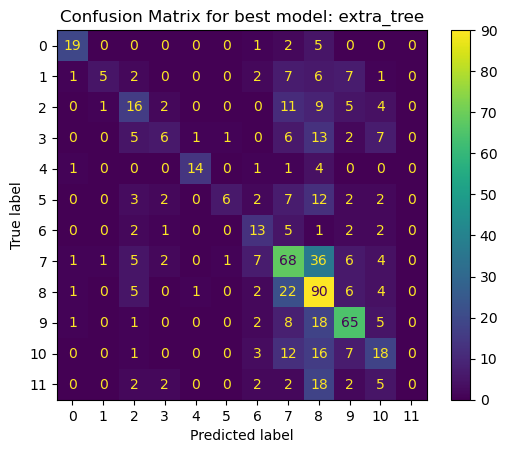

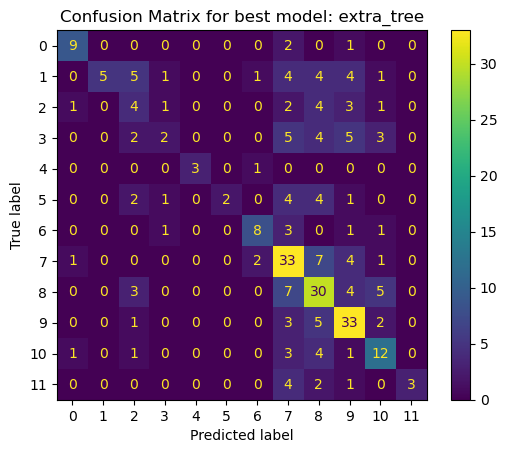

Accuracy: 0.5161290322580645


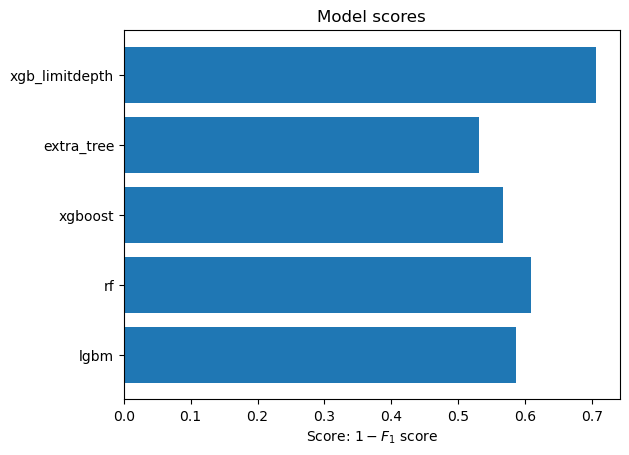

In [37]:
# embeddings = esm_output['representations'][layer]

# automl, X_train, X_val, X_test, y_train, y_val, y_test  = run_automl(esm_output,pool='cdr',run_time=600)
# report_automl(automl)

automl, X_train, X_val, X_test, y_train, y_val, y_test  = run_automl(esm_output,pool='full_seq',run_time=600)
report_automl(automl)


## cdr Sequence Mean pool

In [6]:
layer=36
embeddings = esm_output['representations'][layer]
X_full = extract_mean_rep(data, esm_output['representations'][layer], mean_method='cdr',chain_choice = "together",linker_size=1)

1


In [9]:
X_train = X_full[data['partition'] == 'Train']
X_val = X_full[data['partition'] == 'Validation']
X_test = X_full[data['partition'] == 'Test']
y_train = data.loc[data['partition'] == 'Train', 'Epitope Group'].values
y_val = data.loc[data['partition'] == 'Validation', 'Epitope Group'].values
y_test = data.loc[data['partition'] == 'Test', 'Epitope Group'].values

In [10]:
class_count = Counter(y_train)
print(class_count
)
print(min(class_count.values()) / max(class_count.values()))

Counter({'E2.2': 356, 'E3': 319, 'F1': 316, 'F2': 226, 'A': 180, 'C': 150, 'E2.1': 138, 'D1': 122, 'B': 108, 'D2': 63, 'F3': 60, 'E1': 52})
0.14606741573033707


## AutoML

In [11]:
train_dataset = pd.DataFrame(X_train)
train_dataset['Class'] = y_train
display(train_dataset)
val_dataset = pd.DataFrame(X_val)
val_dataset['Class'] = y_val
display(val_dataset)

,0,1,2,3,4,5,6,7,8,9,...,5111,5112,5113,5114,5115,5116,5117,5118,5119,Class
0,0.053609,0.058729,0.048914,-0.092949,0.039266,-0.109788,-0.183200,-0.104320,0.036359,0.030293,...,-0.033711,-0.005975,0.087326,0.128393,-0.120777,-0.008432,-0.100077,-0.058330,-0.084468,A
1,0.093489,0.064327,0.050353,-0.083450,0.030416,-0.131859,-0.169350,-0.086602,0.051649,-0.003947,...,-0.073365,-0.058829,0.074451,0.116731,-0.093609,0.010259,-0.077685,-0.070691,0.020854,B
2,0.092096,0.089266,0.034348,-0.105342,0.059823,-0.103171,-0.208343,-0.124758,0.064605,0.019246,...,-0.031549,-0.020280,0.059819,0.121716,-0.094612,-0.003087,-0.084078,-0.075099,-0.038416,F2
3,0.096414,0.071231,0.057538,-0.105368,0.034233,-0.109285,-0.159220,-0.060512,0.036305,-0.019292,...,-0.048112,-0.025715,0.056150,0.126317,-0.148788,-0.018574,-0.046751,-0.130757,-0.030812,C
4,0.093823,0.064008,0.071161,-0.112438,0.072177,-0.134030,-0.180600,-0.088825,0.026744,0.033813,...,-0.036563,-0.021141,0.100199,0.111705,-0.129291,-0.029783,-0.058652,-0.083943,-0.043972,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2085,0.059147,0.064678,0.091424,-0.094169,0.016594,-0.098821,-0.156108,-0.040084,0.025023,0.014020,...,-0.002537,-0.018569,0.070026,0.111963,-0.092549,0.026160,-0.061819,-0.107186,0.021812,F1
2086,0.072064,0.052330,0.085037,-0.074971,0.074433,-0.106863,-0.139332,-0.066164,0.034367,-0.010200,...,-0.070021,-0.053806,0.088147,0.101263,-0.145549,0.013026,-0.059007,-0.061958,-0.016123,F1
2087,0.127407,0.074656,0.058815,-0.094195,0.042852,-0.103280,-0.135901,-0.042518,0.038820,0.017678,...,-0.050822,-0.011220,0.081585,0.124917,-0.131246,-0.015166,-0.076883,-0.080630,-0.054626,E2.2
2088,0.075723,0.072291,0.105985,-0.107369,0.046288,-0.107932,-0.161639,-0.055497,0.021777,0.011233,...,-0.074590,-0.028421,0.078886,0.089195,-0.143464,0.006260,-0.049320,-0.065099,-0.050476,F2


,0,1,2,3,4,5,6,7,8,9,...,5111,5112,5113,5114,5115,5116,5117,5118,5119,Class
0,0.067408,0.038656,0.055500,-0.071135,0.041208,-0.099358,-0.127148,-0.066531,0.052935,-0.028867,...,-0.078506,-0.035238,0.051114,0.125742,-0.175653,-0.040784,-0.037415,-0.105899,-0.039503,C
1,0.105641,0.066045,0.045528,-0.090918,0.038007,-0.116821,-0.170194,-0.101098,0.022407,0.017271,...,-0.040460,-0.035667,0.064087,0.137733,-0.119997,-0.083793,-0.098136,-0.079301,-0.035732,C
2,0.064742,0.066132,0.107885,-0.077165,0.026635,-0.112410,-0.135665,-0.036114,0.042179,-0.000825,...,-0.050278,-0.038966,0.090978,0.136755,-0.131529,0.018536,-0.075602,-0.066769,-0.016537,B
3,0.081751,0.073730,0.052301,-0.095751,0.046144,-0.061735,-0.177132,-0.086544,0.016535,-0.018052,...,-0.020257,-0.031954,0.060424,0.133014,-0.109960,0.000031,-0.080030,-0.074548,-0.005197,C
4,0.064742,0.066132,0.107885,-0.077165,0.026635,-0.112410,-0.135665,-0.036114,0.042179,-0.000825,...,-0.050278,-0.038966,0.090978,0.136755,-0.131529,0.018536,-0.075602,-0.066769,-0.016537,F3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,0.075654,0.071483,0.036686,-0.091483,0.073855,-0.088295,-0.143349,-0.031874,0.021978,0.018671,...,-0.051797,-0.054656,0.086669,0.079523,-0.130159,0.003307,-0.054479,-0.067786,-0.036354,E2.2
678,0.110409,0.115483,0.070774,-0.092728,0.022343,-0.094449,-0.157264,-0.111626,0.055545,0.016686,...,-0.027762,-0.012121,0.080426,0.111698,-0.140746,-0.003209,-0.083422,-0.060883,-0.032041,E1
679,0.083222,0.055247,0.072783,-0.084179,0.043452,-0.071748,-0.203883,-0.085948,0.045687,-0.008630,...,-0.032553,-0.006198,0.074712,0.108557,-0.133625,0.014836,-0.081739,-0.058822,-0.035119,E2.2
680,0.083155,0.016821,0.048371,-0.079650,0.026596,-0.090259,-0.122879,-0.094584,0.021560,0.015043,...,0.004894,-0.037742,0.090300,0.128439,-0.099655,-0.006730,-0.066707,-0.116138,0.034844,F1


In [ ]:
from flaml import AutoML

time = 60*60*1
settings = {
    "time_budget": 3600/2,  # total running time in seconds
    # "max_iter": 2,
    "metric": 'micro_f1', 
                        # check the documentation for options of metrics (https://microsoft.github.io/FLAML/docs/Use-Cases/Task-Oriented-AutoML#optimization-metric)
    "task": 'classification',  # task type
    "log_file_name": 'autoML_classification.log',  # flaml log file
    # "training_data": train_dataset,
    # "validation_data": val_dataset,
    # "label_column_name": "Class",
    "n_jobs": 20, # Give full cpu usage when running on Azure Compute
    "seed": 7654321,    # random seed
}

automl = AutoML()
automl.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, **settings)

[flaml.automl.logger: 01-23 07:55:30] {1680} INFO - task = classification
[flaml.automl.logger: 01-23 07:55:30] {1688} INFO - Data split method: stratified
[flaml.automl.logger: 01-23 07:55:30] {1691} INFO - Evaluation method: holdout
[flaml.automl.logger: 01-23 07:55:30] {1789} INFO - Minimizing error metric: 1-micro_f1
[flaml.automl.logger: 01-23 07:55:30] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 01-23 07:55:30] {2219} INFO - iteration 0, current learner lgbm


/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-23 07:55:31] {2345} INFO - Estimated sufficient time budget=11760s. Estimated necessary time budget=271s.
[flaml.automl.logger: 01-23 07:55:31] {2392} INFO -  at 1.3s,	estimator lgbm's best error=0.6290,	best estimator lgbm's best error=0.6290
[flaml.automl.logger: 01-23 07:55:31] {2219} INFO - iteration 1, current learner lgbm


/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-23 07:55:32] {2392} INFO -  at 2.1s,	estimator lgbm's best error=0.6290,	best estimator lgbm's best error=0.6290
[flaml.automl.logger: 01-23 07:55:32] {2219} INFO - iteration 2, current learner lgbm


/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-23 07:55:35] {2392} INFO -  at 4.9s,	estimator lgbm's best error=0.5850,	best estimator lgbm's best error=0.5850
[flaml.automl.logger: 01-23 07:55:35] {2219} INFO - iteration 3, current learner xgboost


/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-23 07:55:37] {2392} INFO -  at 7.5s,	estimator xgboost's best error=0.6393,	best estimator lgbm's best error=0.5850
[flaml.automl.logger: 01-23 07:55:37] {2219} INFO - iteration 4, current learner extra_tree
[flaml.automl.logger: 01-23 07:55:38] {2392} INFO -  at 7.6s,	estimator extra_tree's best error=0.7786,	best estimator lgbm's best error=0.5850
[flaml.automl.logger: 01-23 07:55:38] {2219} INFO - iteration 5, current learner lgbm


/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-23 07:55:50] {2392} INFO -  at 20.2s,	estimator lgbm's best error=0.5733,	best estimator lgbm's best error=0.5733
[flaml.automl.logger: 01-23 07:55:50] {2219} INFO - iteration 6, current learner extra_tree
[flaml.automl.logger: 01-23 07:55:50] {2392} INFO -  at 20.3s,	estimator extra_tree's best error=0.7522,	best estimator lgbm's best error=0.5733
[flaml.automl.logger: 01-23 07:55:50] {2219} INFO - iteration 7, current learner xgboost


/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-23 07:55:53] {2392} INFO -  at 23.4s,	estimator xgboost's best error=0.6393,	best estimator lgbm's best error=0.5733
[flaml.automl.logger: 01-23 07:55:53] {2219} INFO - iteration 8, current learner xgboost
[flaml.automl.logger: 01-23 07:56:03] {2392} INFO -  at 33.3s,	estimator xgboost's best error=0.5733,	best estimator lgbm's best error=0.5733
[flaml.automl.logger: 01-23 07:56:03] {2219} INFO - iteration 9, current learner xgboost
[flaml.automl.logger: 01-23 07:56:33] {2392} INFO -  at 63.3s,	estimator xgboost's best error=0.5455,	best estimator xgboost's best error=0.5455
[flaml.automl.logger: 01-23 07:56:33] {2219} INFO - iteration 10, current learner extra_tree
[flaml.automl.logger: 01-23 07:56:34] {2392} INFO -  at 63.5s,	estimator extra_tree's best error=0.7522,	best estimator xgboost's best error=0.5455
[flaml.automl.logger: 01-23 07:56:34] {2219} INFO - iteration 11, current learner rf
[flaml.automl.logger: 01-23 07:56:34] {2392} INFO -  at 63.8s,	esti

/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-23 07:57:01] {2392} INFO -  at 90.9s,	estimator lgbm's best error=0.5616,	best estimator xgboost's best error=0.5455
[flaml.automl.logger: 01-23 07:57:01] {2219} INFO - iteration 19, current learner xgboost


/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-23 07:57:10] {2392} INFO -  at 100.4s,	estimator xgboost's best error=0.5455,	best estimator xgboost's best error=0.5455
[flaml.automl.logger: 01-23 07:57:10] {2219} INFO - iteration 20, current learner rf
[flaml.automl.logger: 01-23 07:57:11] {2392} INFO -  at 100.8s,	estimator rf's best error=0.6994,	best estimator xgboost's best error=0.5455
[flaml.automl.logger: 01-23 07:57:11] {2219} INFO - iteration 21, current learner rf
[flaml.automl.logger: 01-23 07:57:11] {2392} INFO -  at 101.3s,	estimator rf's best error=0.6994,	best estimator xgboost's best error=0.5455
[flaml.automl.logger: 01-23 07:57:11] {2219} INFO - iteration 22, current learner rf
[flaml.automl.logger: 01-23 07:57:12] {2392} INFO -  at 101.9s,	estimator rf's best error=0.6994,	best estimator xgboost's best error=0.5455
[flaml.automl.logger: 01-23 07:57:12] {2219} INFO - iteration 23, current learner rf
[flaml.automl.logger: 01-23 07:57:13] {2392} INFO -  at 102.7s,	estimator rf's best error=0

/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-23 07:57:26] {2392} INFO -  at 115.7s,	estimator lgbm's best error=0.5587,	best estimator xgboost's best error=0.5455
[flaml.automl.logger: 01-23 07:57:26] {2219} INFO - iteration 31, current learner lgbm


/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-23 07:57:35] {2392} INFO -  at 124.6s,	estimator lgbm's best error=0.5587,	best estimator xgboost's best error=0.5455
[flaml.automl.logger: 01-23 07:57:35] {2219} INFO - iteration 32, current learner rf


/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-23 07:57:35] {2392} INFO -  at 125.3s,	estimator rf's best error=0.6804,	best estimator xgboost's best error=0.5455
[flaml.automl.logger: 01-23 07:57:35] {2219} INFO - iteration 33, current learner extra_tree
[flaml.automl.logger: 01-23 07:57:35] {2392} INFO -  at 125.4s,	estimator extra_tree's best error=0.6950,	best estimator xgboost's best error=0.5455
[flaml.automl.logger: 01-23 07:57:35] {2219} INFO - iteration 34, current learner rf
[flaml.automl.logger: 01-23 07:57:37] {2392} INFO -  at 126.9s,	estimator rf's best error=0.6804,	best estimator xgboost's best error=0.5455
[flaml.automl.logger: 01-23 07:57:37] {2219} INFO - iteration 35, current learner extra_tree
[flaml.automl.logger: 01-23 07:57:37] {2392} INFO -  at 127.0s,	estimator extra_tree's best error=0.6950,	best estimator xgboost's best error=0.5455
[flaml.automl.logger: 01-23 07:57:37] {2219} INFO - iteration 36, current learner extra_tree
[flaml.automl.logger: 01-23 07:57:37] {2392} INFO -  at 

/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-23 07:59:26] {2392} INFO -  at 236.0s,	estimator lgbm's best error=0.5587,	best estimator xgboost's best error=0.5396
[flaml.automl.logger: 01-23 07:59:26] {2219} INFO - iteration 55, current learner extra_tree


/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-23 07:59:26] {2392} INFO -  at 236.3s,	estimator extra_tree's best error=0.5733,	best estimator xgboost's best error=0.5396
[flaml.automl.logger: 01-23 07:59:26] {2219} INFO - iteration 56, current learner rf
[flaml.automl.logger: 01-23 07:59:27] {2392} INFO -  at 236.9s,	estimator rf's best error=0.6642,	best estimator xgboost's best error=0.5396
[flaml.automl.logger: 01-23 07:59:27] {2219} INFO - iteration 57, current learner xgboost
[flaml.automl.logger: 01-23 08:01:35] {2392} INFO -  at 364.9s,	estimator xgboost's best error=0.5396,	best estimator xgboost's best error=0.5396
[flaml.automl.logger: 01-23 08:01:35] {2219} INFO - iteration 58, current learner extra_tree
[flaml.automl.logger: 01-23 08:01:35] {2392} INFO -  at 365.4s,	estimator extra_tree's best error=0.5733,	best estimator xgboost's best error=0.5396
[flaml.automl.logger: 01-23 08:01:35] {2219} INFO - iteration 59, current learner rf
[flaml.automl.logger: 01-23 08:01:36] {2392} INFO -  at 366.3s

/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-23 08:04:34] {2392} INFO -  at 544.0s,	estimator lgbm's best error=0.5587,	best estimator extra_tree's best error=0.5264
[flaml.automl.logger: 01-23 08:04:34] {2219} INFO - iteration 103, current learner extra_tree


/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-23 08:04:35] {2392} INFO -  at 544.5s,	estimator extra_tree's best error=0.5264,	best estimator extra_tree's best error=0.5264
[flaml.automl.logger: 01-23 08:04:35] {2219} INFO - iteration 104, current learner extra_tree
[flaml.automl.logger: 01-23 08:04:36] {2392} INFO -  at 545.6s,	estimator extra_tree's best error=0.5264,	best estimator extra_tree's best error=0.5264
[flaml.automl.logger: 01-23 08:04:36] {2219} INFO - iteration 105, current learner extra_tree
[flaml.automl.logger: 01-23 08:04:38] {2392} INFO -  at 547.7s,	estimator extra_tree's best error=0.5264,	best estimator extra_tree's best error=0.5264
[flaml.automl.logger: 01-23 08:04:38] {2219} INFO - iteration 106, current learner extra_tree
[flaml.automl.logger: 01-23 08:04:38] {2392} INFO -  at 548.0s,	estimator extra_tree's best error=0.5264,	best estimator extra_tree's best error=0.5264
[flaml.automl.logger: 01-23 08:04:38] {2219} INFO - iteration 107, current learner extra_tree
[flaml.automl.lo

/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-23 08:05:05] {2392} INFO -  at 574.9s,	estimator lgbm's best error=0.5587,	best estimator extra_tree's best error=0.5264
[flaml.automl.logger: 01-23 08:05:05] {2219} INFO - iteration 111, current learner extra_tree


/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-23 08:05:06] {2392} INFO -  at 575.6s,	estimator extra_tree's best error=0.5264,	best estimator extra_tree's best error=0.5264
[flaml.automl.logger: 01-23 08:05:06] {2219} INFO - iteration 112, current learner extra_tree
[flaml.automl.logger: 01-23 08:05:07] {2392} INFO -  at 576.7s,	estimator extra_tree's best error=0.5264,	best estimator extra_tree's best error=0.5264
[flaml.automl.logger: 01-23 08:05:07] {2219} INFO - iteration 113, current learner extra_tree
[flaml.automl.logger: 01-23 08:05:07] {2392} INFO -  at 577.1s,	estimator extra_tree's best error=0.5264,	best estimator extra_tree's best error=0.5264
[flaml.automl.logger: 01-23 08:05:07] {2219} INFO - iteration 114, current learner rf
[flaml.automl.logger: 01-23 08:05:10] {2392} INFO -  at 579.6s,	estimator rf's best error=0.6085,	best estimator extra_tree's best error=0.5264
[flaml.automl.logger: 01-23 08:05:10] {2219} INFO - iteration 115, current learner rf
[flaml.automl.logger: 01-23 08:05:11] {2

/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-23 08:05:52] {2392} INFO -  at 621.5s,	estimator lgbm's best error=0.5587,	best estimator extra_tree's best error=0.5220
[flaml.automl.logger: 01-23 08:05:52] {2219} INFO - iteration 154, current learner extra_tree


/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-23 08:05:52] {2392} INFO -  at 622.1s,	estimator extra_tree's best error=0.5220,	best estimator extra_tree's best error=0.5220
[flaml.automl.logger: 01-23 08:05:52] {2219} INFO - iteration 155, current learner extra_tree
[flaml.automl.logger: 01-23 08:05:54] {2392} INFO -  at 623.6s,	estimator extra_tree's best error=0.5220,	best estimator extra_tree's best error=0.5220
[flaml.automl.logger: 01-23 08:05:54] {2219} INFO - iteration 156, current learner extra_tree
[flaml.automl.logger: 01-23 08:05:54] {2392} INFO -  at 624.1s,	estimator extra_tree's best error=0.5220,	best estimator extra_tree's best error=0.5220
[flaml.automl.logger: 01-23 08:05:54] {2219} INFO - iteration 157, current learner extra_tree
[flaml.automl.logger: 01-23 08:05:55] {2392} INFO -  at 625.3s,	estimator extra_tree's best error=0.5220,	best estimator extra_tree's best error=0.5220
[flaml.automl.logger: 01-23 08:05:55] {2219} INFO - iteration 158, current learner extra_tree
[flaml.automl.lo

/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-23 08:06:18] {2392} INFO -  at 647.8s,	estimator lgbm's best error=0.5587,	best estimator extra_tree's best error=0.5220
[flaml.automl.logger: 01-23 08:06:18] {2219} INFO - iteration 170, current learner rf


/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-23 08:06:20] {2392} INFO -  at 649.5s,	estimator rf's best error=0.6012,	best estimator extra_tree's best error=0.5220
[flaml.automl.logger: 01-23 08:06:20] {2219} INFO - iteration 171, current learner extra_tree
[flaml.automl.logger: 01-23 08:06:20] {2392} INFO -  at 650.4s,	estimator extra_tree's best error=0.5220,	best estimator extra_tree's best error=0.5220
[flaml.automl.logger: 01-23 08:06:20] {2219} INFO - iteration 172, current learner extra_tree
[flaml.automl.logger: 01-23 08:06:21] {2392} INFO -  at 651.2s,	estimator extra_tree's best error=0.5220,	best estimator extra_tree's best error=0.5220
[flaml.automl.logger: 01-23 08:06:21] {2219} INFO - iteration 173, current learner extra_tree
[flaml.automl.logger: 01-23 08:06:22] {2392} INFO -  at 651.8s,	estimator extra_tree's best error=0.5220,	best estimator extra_tree's best error=0.5220
[flaml.automl.logger: 01-23 08:06:22] {2219} INFO - iteration 174, current learner extra_tree
[flaml.automl.logger: 01

/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-23 08:08:19] {2392} INFO -  at 769.1s,	estimator lgbm's best error=0.5572,	best estimator extra_tree's best error=0.5220
[flaml.automl.logger: 01-23 08:08:19] {2219} INFO - iteration 201, current learner extra_tree


/anaconda/envs/aipro/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-23 08:08:20] {2392} INFO -  at 770.3s,	estimator extra_tree's best error=0.5220,	best estimator extra_tree's best error=0.5220
[flaml.automl.logger: 01-23 08:08:20] {2219} INFO - iteration 202, current learner extra_tree
[flaml.automl.logger: 01-23 08:08:22] {2392} INFO -  at 771.7s,	estimator extra_tree's best error=0.5220,	best estimator extra_tree's best error=0.5220
[flaml.automl.logger: 01-23 08:08:22] {2219} INFO - iteration 203, current learner extra_tree
[flaml.automl.logger: 01-23 08:08:22] {2392} INFO -  at 772.2s,	estimator extra_tree's best error=0.5220,	best estimator extra_tree's best error=0.5220
[flaml.automl.logger: 01-23 08:08:22] {2219} INFO - iteration 204, current learner extra_tree
[flaml.automl.logger: 01-23 08:08:23] {2392} INFO -  at 772.8s,	estimator extra_tree's best error=0.5220,	best estimator extra_tree's best error=0.5220
[flaml.automl.logger: 01-23 08:08:23] {2219} INFO - iteration 205, current learner extra_tree
[flaml.automl.lo

In [20]:
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: extra_tree
Best hyperparmeter config: {'n_estimators': 194, 'max_features': np.float64(0.06265314330316614), 'max_leaves': 900, 'criterion': np.str_('gini')}
Best accuracy on validation data: 0.4824
Training duration of best run: 1.992 s


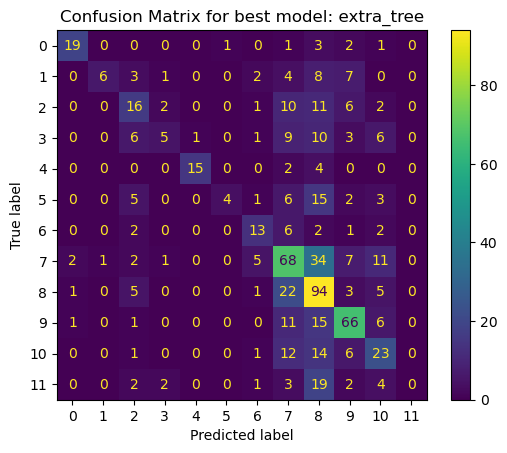

In [21]:
y_pred = automl.predict(X_val)
# print('Predicted labels', y_pred)
# print('True labels', y_test)
y_pred_proba = automl.predict_proba(X_val)[:,1]
cm = confusion_matrix(y_val, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title(f'Confusion Matrix for best model: {automl.best_estimator}')
plt.show()

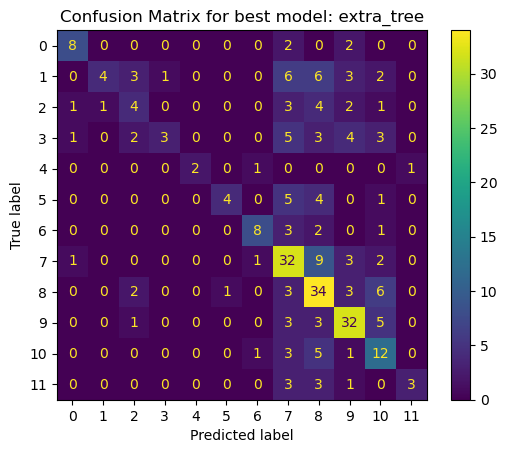

In [22]:
y_pred = automl.predict(X_test)
# print('Predicted labels', y_pred)
# print('True labels', y_test)
y_pred_proba = automl.predict_proba(X_test)[:,1]
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title(f'Confusion Matrix for best model: {automl.best_estimator}')
plt.show()

In [23]:
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.5232974910394266


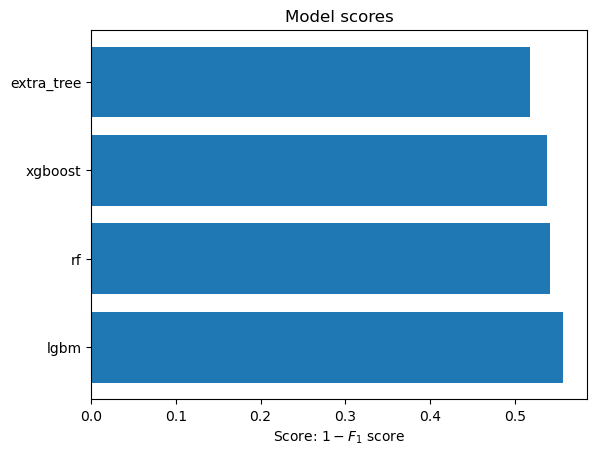

In [24]:
plt.barh(automl.best_loss_per_estimator.keys(), automl.best_loss_per_estimator.values())
plt.xlabel('Score: $1-F_1$ score')
plt.title('Model scores')
plt.show()

## CDR Mean Pool

In [34]:
layer=36
embeddings = esm_output['representations'][layer]
X_cdr = extract_mean_rep(data, embeddings, mean_method='cdr')

In [35]:
X_train = X_cdr[data['partition'] == 'Train']
X_val = X_cdr[data['partition'] == 'Validation']
X_test = X_cdr[data['partition'] == 'Test']
y_train = data.loc[data['partition'] == 'Train', 'Epitope Group'].values
y_val = data.loc[data['partition'] == 'Validation', 'Epitope Group'].values
y_test = data.loc[data['partition'] == 'Test', 'Epitope Group'].values

In [36]:
class_count = Counter(y_train)
print(class_count
)
print(min(class_count.values()) / max(class_count.values()))

Counter({'E2.2': 356, 'E3': 319, 'F1': 316, 'F2': 226, 'A': 180, 'C': 150, 'E2.1': 138, 'D1': 122, 'B': 108, 'D2': 63, 'F3': 60, 'E1': 52})
0.14606741573033707


### Oversampling - Do not use

In [ ]:
ros = over_sampling.RandomOverSampler(random_state=1)
X_res, y_res = ros.fit_resample(X_train, y_train)
Counter(y_res)

Counter({'A': 356,
         'B': 356,
         'F2': 356,
         'C': 356,
         'E2.2': 356,
         'D2': 356,
         'F3': 356,
         'E1': 356,
         'E2.1': 356,
         'D1': 356,
         'E3': 356,
         'F1': 356})

In [ ]:
sm = over_sampling.SMOTE(random_state=1)
X_res, y_res = sm.fit_resample(X_train, y_train)
Counter(y_res)

Counter({'A': 356,
         'B': 356,
         'F2': 356,
         'C': 356,
         'E2.2': 356,
         'D2': 356,
         'F3': 356,
         'E1': 356,
         'E2.1': 356,
         'D1': 356,
         'E3': 356,
         'F1': 356})

from collections import Counter
Counter(y_res)

## KNN classifier as baseline

In [37]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [38]:
y_pred = neigh.predict(X_val)

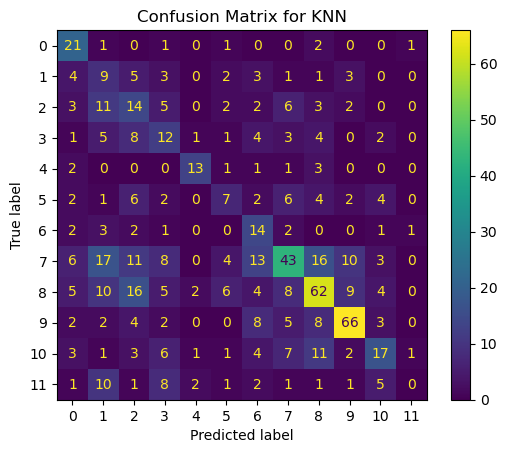

In [39]:
cm = confusion_matrix(y_val, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title(f'Confusion Matrix for KNN')
plt.show()

In [40]:
print('Accuracy:', accuracy_score(y_val, y_pred))

Accuracy: 0.40762463343108507


## AutoML

In [41]:
train_dataset = pd.DataFrame(X_train)
train_dataset['Class'] = y_train
display(train_dataset)
val_dataset = pd.DataFrame(X_val)
val_dataset['Class'] = y_val
display(val_dataset)

,0,1,2,3,4,5,6,7,8,9,...,5111,5112,5113,5114,5115,5116,5117,5118,5119,Class
0,0.043252,0.072683,0.042855,-0.073725,0.018577,-0.091522,-0.181655,-0.092990,0.037061,0.036209,...,-0.056876,-0.015514,0.085547,0.124902,-0.131320,-0.007207,-0.092779,-0.041054,-0.084789,A
1,0.061437,0.056245,0.024487,-0.086864,0.006944,-0.118434,-0.156948,-0.080117,0.049105,0.003954,...,-0.086994,-0.047620,0.066176,0.126077,-0.106619,0.012497,-0.071489,-0.049455,0.000793,B
2,0.069560,0.081303,0.031303,-0.105566,0.038904,-0.084756,-0.205413,-0.109782,0.070213,0.016857,...,-0.067997,-0.023113,0.061442,0.127017,-0.109417,-0.003028,-0.059038,-0.054691,-0.042894,F2
3,0.063967,0.057003,0.033576,-0.093780,0.000299,-0.105917,-0.128271,-0.050570,0.041709,-0.018479,...,-0.060558,-0.016726,0.047174,0.128183,-0.154048,-0.017450,-0.051420,-0.127369,-0.031085,C
4,0.075205,0.081634,0.037149,-0.104874,0.029566,-0.118894,-0.175116,-0.081351,0.030245,0.025451,...,-0.042179,-0.035713,0.085356,0.104165,-0.132707,-0.029635,-0.040184,-0.059261,-0.050365,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2085,0.036032,0.069400,0.083863,-0.097580,-0.011969,-0.076862,-0.139238,-0.027624,0.012115,0.016316,...,-0.008938,-0.035577,0.072980,0.101709,-0.103482,0.023392,-0.054240,-0.085937,-0.002443,F1
2086,0.036267,0.046279,0.051569,-0.058172,0.029512,-0.109340,-0.131534,-0.043564,0.038981,-0.012963,...,-0.074688,-0.061749,0.078466,0.113634,-0.151335,0.003225,-0.044762,-0.038964,-0.029941,F1
2087,0.100824,0.085600,0.043680,-0.087364,0.011241,-0.095129,-0.119705,-0.025033,0.047632,0.020174,...,-0.065643,-0.014770,0.078463,0.131052,-0.148332,-0.014985,-0.071555,-0.046811,-0.057487,E2.2
2088,0.049512,0.069644,0.070050,-0.084705,0.009929,-0.109365,-0.162464,-0.046585,0.028938,0.004629,...,-0.074007,-0.047343,0.069047,0.105878,-0.148023,-0.010560,-0.032600,-0.034252,-0.061155,F2


,0,1,2,3,4,5,6,7,8,9,...,5111,5112,5113,5114,5115,5116,5117,5118,5119,Class
0,0.045610,0.027476,0.038892,-0.055843,0.010486,-0.092125,-0.088524,-0.059076,0.044902,-0.022724,...,-0.086153,-0.026617,0.032579,0.130495,-0.185194,-0.043560,-0.038455,-0.098217,-0.033510,C
1,0.080775,0.069291,0.041128,-0.093243,0.022048,-0.100222,-0.150226,-0.083055,0.037842,0.019660,...,-0.050302,-0.037645,0.048087,0.156115,-0.127753,-0.080179,-0.094736,-0.057907,-0.042071,C
2,0.042505,0.070799,0.082090,-0.082763,-0.007396,-0.103019,-0.125514,-0.025697,0.048286,-0.009785,...,-0.064754,-0.040526,0.089341,0.137937,-0.141704,0.011480,-0.052495,-0.030890,-0.040360,B
3,0.079011,0.072792,0.040124,-0.094209,0.013651,-0.042501,-0.151606,-0.076563,0.018184,-0.015755,...,-0.054138,-0.037149,0.070127,0.131281,-0.143289,0.002905,-0.059125,-0.048333,-0.008122,C
4,0.042505,0.070799,0.082090,-0.082763,-0.007396,-0.103019,-0.125514,-0.025697,0.048286,-0.009785,...,-0.064754,-0.040526,0.089341,0.137937,-0.141704,0.011480,-0.052495,-0.030890,-0.040360,F3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,0.039687,0.070357,0.005672,-0.097238,0.039244,-0.087399,-0.126398,-0.029475,0.024430,0.015074,...,-0.070456,-0.048213,0.091205,0.090242,-0.139743,-0.006967,-0.040933,-0.034024,-0.049247,E2.2
678,0.089113,0.099590,0.050975,-0.101106,-0.003393,-0.086969,-0.149707,-0.106932,0.054940,0.030239,...,-0.054094,-0.019008,0.083585,0.126228,-0.145512,-0.001693,-0.075911,-0.037597,-0.049647,E1
679,0.080171,0.053475,0.052616,-0.088057,0.017165,-0.051748,-0.189001,-0.074407,0.044561,-0.002528,...,-0.056534,-0.026290,0.078742,0.120994,-0.152553,0.008455,-0.066141,-0.047218,-0.047077,E2.2
680,0.075917,0.028246,0.049015,-0.076641,0.014523,-0.076563,-0.108488,-0.073491,0.021811,0.006280,...,-0.001589,-0.029103,0.089530,0.111080,-0.118346,0.007973,-0.060818,-0.103879,0.022043,F1


In [42]:
settings = {
    "time_budget": 600,  # total running time in seconds
    # "max_iter": 2,
    "metric": 'micro_f1', 
                        # check the documentation for options of metrics (https://microsoft.github.io/FLAML/docs/Use-Cases/Task-Oriented-AutoML#optimization-metric)
    "task": 'classification',  # task type
    "log_file_name": 'autoML_classification.log',  # flaml log file
    # "training_data": train_dataset,
    # "validation_data": val_dataset,
    # "label_column_name": "Class",
    "n_jobs": 16, # Give full cpu usage when running on Azure Compute
    "seed": 7654321,    # random seed
}

automl = AutoML()
automl.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, **settings)

[flaml.automl.logger: 01-22 10:08:19] {1680} INFO - task = classification
[flaml.automl.logger: 01-22 10:08:19] {1688} INFO - Data split method: stratified
[flaml.automl.logger: 01-22 10:08:19] {1691} INFO - Evaluation method: holdout
[flaml.automl.logger: 01-22 10:08:19] {1789} INFO - Minimizing error metric: 1-micro_f1
[flaml.automl.logger: 01-22 10:08:19] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 01-22 10:08:19] {2219} INFO - iteration 0, current learner lgbm


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-22 10:08:20] {2345} INFO - Estimated sufficient time budget=11197s. Estimated necessary time budget=258s.
[flaml.automl.logger: 01-22 10:08:20] {2392} INFO -  at 1.2s,	estimator lgbm's best error=0.6334,	best estimator lgbm's best error=0.6334
[flaml.automl.logger: 01-22 10:08:20] {2219} INFO - iteration 1, current learner lgbm


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-22 10:08:21] {2392} INFO -  at 2.0s,	estimator lgbm's best error=0.6334,	best estimator lgbm's best error=0.6334
[flaml.automl.logger: 01-22 10:08:21] {2219} INFO - iteration 2, current learner lgbm


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-22 10:08:25] {2392} INFO -  at 5.2s,	estimator lgbm's best error=0.5880,	best estimator lgbm's best error=0.5880
[flaml.automl.logger: 01-22 10:08:25] {2219} INFO - iteration 3, current learner xgboost


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-22 10:08:27] {2392} INFO -  at 7.7s,	estimator xgboost's best error=0.6408,	best estimator lgbm's best error=0.5880
[flaml.automl.logger: 01-22 10:08:27] {2219} INFO - iteration 4, current learner extra_tree
[flaml.automl.logger: 01-22 10:08:27] {2392} INFO -  at 7.8s,	estimator extra_tree's best error=0.7375,	best estimator lgbm's best error=0.5880
[flaml.automl.logger: 01-22 10:08:27] {2219} INFO - iteration 5, current learner lgbm


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-22 10:08:42] {2392} INFO -  at 22.8s,	estimator lgbm's best error=0.5601,	best estimator lgbm's best error=0.5601
[flaml.automl.logger: 01-22 10:08:42] {2219} INFO - iteration 6, current learner extra_tree
[flaml.automl.logger: 01-22 10:08:42] {2392} INFO -  at 22.9s,	estimator extra_tree's best error=0.7375,	best estimator lgbm's best error=0.5601
[flaml.automl.logger: 01-22 10:08:42] {2219} INFO - iteration 7, current learner extra_tree
[flaml.automl.logger: 01-22 10:08:42] {2392} INFO -  at 23.0s,	estimator extra_tree's best error=0.7375,	best estimator lgbm's best error=0.5601
[flaml.automl.logger: 01-22 10:08:42] {2219} INFO - iteration 8, current learner extra_tree


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-22 10:08:42] {2392} INFO -  at 23.1s,	estimator extra_tree's best error=0.7375,	best estimator lgbm's best error=0.5601
[flaml.automl.logger: 01-22 10:08:42] {2219} INFO - iteration 9, current learner extra_tree
[flaml.automl.logger: 01-22 10:08:43] {2392} INFO -  at 23.2s,	estimator extra_tree's best error=0.7302,	best estimator lgbm's best error=0.5601
[flaml.automl.logger: 01-22 10:08:43] {2219} INFO - iteration 10, current learner rf
[flaml.automl.logger: 01-22 10:08:43] {2392} INFO -  at 23.5s,	estimator rf's best error=0.8065,	best estimator lgbm's best error=0.5601
[flaml.automl.logger: 01-22 10:08:43] {2219} INFO - iteration 11, current learner rf
[flaml.automl.logger: 01-22 10:08:43] {2392} INFO -  at 23.6s,	estimator rf's best error=0.7625,	best estimator lgbm's best error=0.5601
[flaml.automl.logger: 01-22 10:08:43] {2219} INFO - iteration 12, current learner rf
[flaml.automl.logger: 01-22 10:08:43] {2392} INFO -  at 23.9s,	estimator rf's best error=

/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-22 10:09:27] {2392} INFO -  at 68.0s,	estimator lgbm's best error=0.5601,	best estimator lgbm's best error=0.5601
[flaml.automl.logger: 01-22 10:09:27] {2219} INFO - iteration 19, current learner extra_tree
[flaml.automl.logger: 01-22 10:09:27] {2392} INFO -  at 68.1s,	estimator extra_tree's best error=0.7273,	best estimator lgbm's best error=0.5601
[flaml.automl.logger: 01-22 10:09:27] {2219} INFO - iteration 20, current learner xgboost


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-22 10:09:53] {2392} INFO -  at 93.5s,	estimator xgboost's best error=0.5440,	best estimator xgboost's best error=0.5440
[flaml.automl.logger: 01-22 10:09:53] {2219} INFO - iteration 21, current learner xgboost
[flaml.automl.logger: 01-22 10:10:02] {2392} INFO -  at 102.2s,	estimator xgboost's best error=0.5440,	best estimator xgboost's best error=0.5440
[flaml.automl.logger: 01-22 10:10:02] {2219} INFO - iteration 22, current learner lgbm


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-22 10:10:04] {2392} INFO -  at 105.0s,	estimator lgbm's best error=0.5601,	best estimator xgboost's best error=0.5440
[flaml.automl.logger: 01-22 10:10:04] {2219} INFO - iteration 23, current learner rf


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-22 10:10:06] {2392} INFO -  at 106.3s,	estimator rf's best error=0.6906,	best estimator xgboost's best error=0.5440
[flaml.automl.logger: 01-22 10:10:06] {2219} INFO - iteration 24, current learner xgboost
[flaml.automl.logger: 01-22 10:10:20] {2392} INFO -  at 120.5s,	estimator xgboost's best error=0.5440,	best estimator xgboost's best error=0.5440
[flaml.automl.logger: 01-22 10:10:20] {2219} INFO - iteration 25, current learner extra_tree
[flaml.automl.logger: 01-22 10:10:20] {2392} INFO -  at 120.7s,	estimator extra_tree's best error=0.6774,	best estimator xgboost's best error=0.5440
[flaml.automl.logger: 01-22 10:10:20] {2219} INFO - iteration 26, current learner extra_tree
[flaml.automl.logger: 01-22 10:10:20] {2392} INFO -  at 120.8s,	estimator extra_tree's best error=0.6774,	best estimator xgboost's best error=0.5440
[flaml.automl.logger: 01-22 10:10:20] {2219} INFO - iteration 27, current learner extra_tree
[flaml.automl.logger: 01-22 10:10:20] {2392} I

/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-22 10:11:26] {2392} INFO -  at 186.5s,	estimator lgbm's best error=0.5601,	best estimator xgboost's best error=0.5381
[flaml.automl.logger: 01-22 10:11:26] {2219} INFO - iteration 43, current learner extra_tree


/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-22 10:11:26] {2392} INFO -  at 186.8s,	estimator extra_tree's best error=0.5674,	best estimator xgboost's best error=0.5381
[flaml.automl.logger: 01-22 10:11:26] {2219} INFO - iteration 44, current learner extra_tree
[flaml.automl.logger: 01-22 10:11:26] {2392} INFO -  at 187.1s,	estimator extra_tree's best error=0.5674,	best estimator xgboost's best error=0.5381
[flaml.automl.logger: 01-22 10:11:26] {2219} INFO - iteration 45, current learner extra_tree
[flaml.automl.logger: 01-22 10:11:27] {2392} INFO -  at 187.3s,	estimator extra_tree's best error=0.5674,	best estimator xgboost's best error=0.5381
[flaml.automl.logger: 01-22 10:11:27] {2219} INFO - iteration 46, current learner extra_tree
[flaml.automl.logger: 01-22 10:11:27] {2392} INFO -  at 187.7s,	estimator extra_tree's best error=0.5674,	best estimator xgboost's best error=0.5381
[flaml.automl.logger: 01-22 10:11:27] {2219} INFO - iteration 47, current learner extra_tree
[flaml.automl.logger: 01-22 10:1

/anaconda/envs/scanpy/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [43]:
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: xgboost
Best hyperparmeter config: {'n_estimators': 84, 'max_leaves': 6, 'min_child_weight': np.float64(1.3029271408842327), 'learning_rate': np.float64(0.0945622496840656), 'subsample': np.float64(0.977951757291235), 'colsample_bylevel': np.float64(0.9344398385890139), 'colsample_bytree': np.float64(0.9621235054574703), 'reg_alpha': np.float64(0.0041668208198370905), 'reg_lambda': np.float64(7.82506683898272)}
Best accuracy on validation data: 0.4897
Training duration of best run: 80.69 s


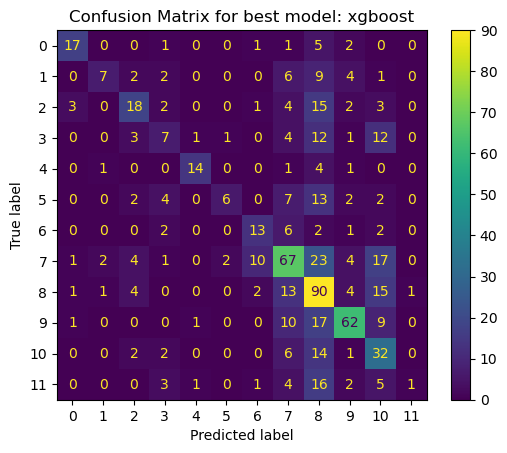

In [44]:
y_pred = automl.predict(X_val)
# print('Predicted labels', y_pred)
# print('True labels', y_test)
y_pred_proba = automl.predict_proba(X_val)[:,1]
cm = confusion_matrix(y_val, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title(f'Confusion Matrix for best model: {automl.best_estimator}')
plt.show()

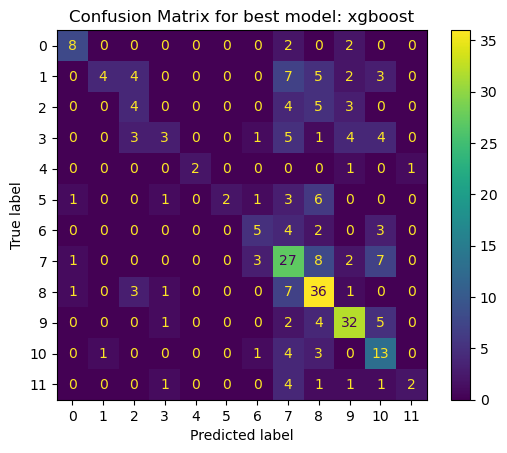

In [45]:
y_pred = automl.predict(X_test)
# print('Predicted labels', y_pred)
# print('True labels', y_test)
y_pred_proba = automl.predict_proba(X_test)[:,1]
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title(f'Confusion Matrix for best model: {automl.best_estimator}')
plt.show()

In [46]:
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.4946236559139785


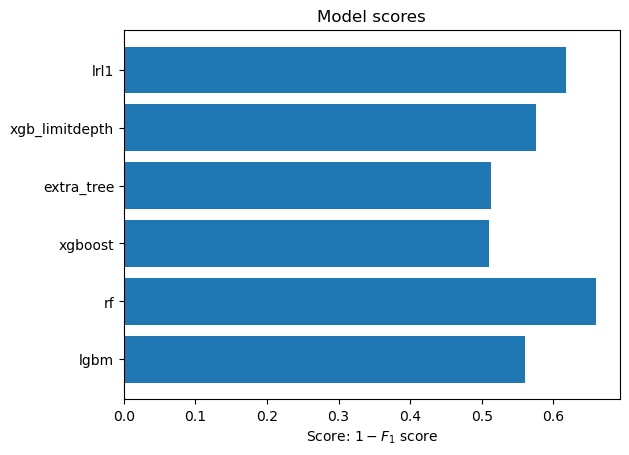

In [47]:
plt.barh(automl.best_loss_per_estimator.keys(), automl.best_loss_per_estimator.values())
plt.xlabel('Score: $1-F_1$ score')
plt.title('Model scores')
plt.show()

## Save best model

In [26]:
import pickle
with open('../models/automl1.pkl', 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)